# Assignment NLP Unit: Text Classification

In [ ]:
# Importing basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Change plot settings to display plots and data
%matplotlib inline
plt.rcParams.update({'font.size': 22})

from IPython.display import HTML
def display_df(df):
    """Displays the dataframe using HTML."""
    return HTML(df.to_html())

In [ ]:
# Loading AG News train and test datasets
train = pd.read_csv("agnews_train.csv")
test = pd.read_csv("agnews_test.csv")

### Exploratory Data Analysis

In [ ]:
# There is a multiclass label and 4 binary labels for each of the classes.
train.head()

,text,label,label_int,science_int,sports_int,world_int,business_int
0,"John Souza, a volunteer with the Boone County ...",Business,3,0,0,0,1
1,Spain needs only to beat an under-strength Fre...,Sports,1,0,1,0,0
2,"PANAMA CITY, Panama -- When the United States ...",World,2,0,0,1,0
3,"Gilbert Arenas, Jarvis Hayes and Anthony Peele...",Sports,1,0,1,0,0
4,"MEMPHIS, Tenn. -- Kobe Bryant had his worst sh...",Sports,1,0,1,0,0


In [ ]:
# We have 2 object variables and 5 interger variables. 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109999 entries, 0 to 109998
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   text          109999 non-null  object
 1   label         109999 non-null  object
 2   label_int     109999 non-null  int64 
 3   science_int   109999 non-null  int64 
 4   sports_int    109999 non-null  int64 
 5   world_int     109999 non-null  int64 
 6   business_int  109999 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 5.9+ MB


In [ ]:
# The data set is balanced: it contains about 25% of articles from each class.
train.describe()

,label_int,science_int,sports_int,world_int,business_int
count,109999.000000,109999.000000,109999.000000,109999.000000,109999.000000
mean,1.500341,0.249657,0.250384,0.249920,0.250039
std,1.117767,0.432816,0.433236,0.432969,0.433037
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.000000,1.000000,0.000000,1.000000
max,3.000000,1.000000,1.000000,1.000000,1.000000


### Feature Extraction

In [ ]:
'''Split separates sentences into words, but it cannot iddentify uppercase and lowercase, 
punctuations sings, and other special characters.'''
sentence = train.text[0]
sentence.split()

['John',
 'Souza,',
 'a',
 'volunteer',
 'with',
 'the',
 'Boone',
 'County',
 'chapter',
 'of',
 'the',
 'American',
 'Red',
 'Cross,',
 'is',
 'the',
 'second',
 'Columbia',
 'resident',
 'to',
 'join',
 'efforts',
 'to',
 'assist',
 'people',
 'who',
 'were',
 'affected',
 'by',
 'Tropical',
 'Storm',
 'Bonnie',
 'and',
 'Hurricane',
 'Charley.']

In [ ]:
# We use the simple sklearn's text analyzer to tokenize sentences into words.
# This function also removes punctuation and other characters, lowercases all words, 
# and removes some unimportant words.
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
def make_sklearn_analyzer(n=1):
    """We first define a convenience function to create an sklearn text analyzer, that
extracts n-grams, up to a given n. The resulting representation is a bag-of-ngrams."""
    vect = CountVectorizer(stop_words=[], ngram_range=(1,n))
    analyzer = vect.build_analyzer()
    return analyzer


sk_analyzer = make_sklearn_analyzer()

In [ ]:
'''We’re now going a distribution of all the words in our collection. With each word, we will
associate a count, that is, how many times does the word appear in the collection.
There are 58831 different words in our collection.'''
from collections import Counter
word_counts = Counter()
for text in train.text:
    word_counts.update(sk_analyzer(text))
len(word_counts.most_common())

58831

In [ ]:
'''Ranking the most common words in our collection. 
The most common words are generally articles, determinants, prepositions, pronouns, or auxiliary verbs.'''
word_counts.most_common(20)

[('the', 182263),
 ('to', 88925),
 ('of', 82101),
 ('in', 72156),
 ('and', 60998),
 ('on', 44011),
 ('for', 35113),
 ('39', 29262),
 ('that', 25467),
 ('with', 20823),
 ('as', 20126),
 ('its', 19440),
 ('at', 19076),
 ('said', 18413),
 ('is', 18395),
 ('it', 17558),
 ('by', 17201),
 ('has', 16768),
 ('new', 16005),
 ('an', 15241)]

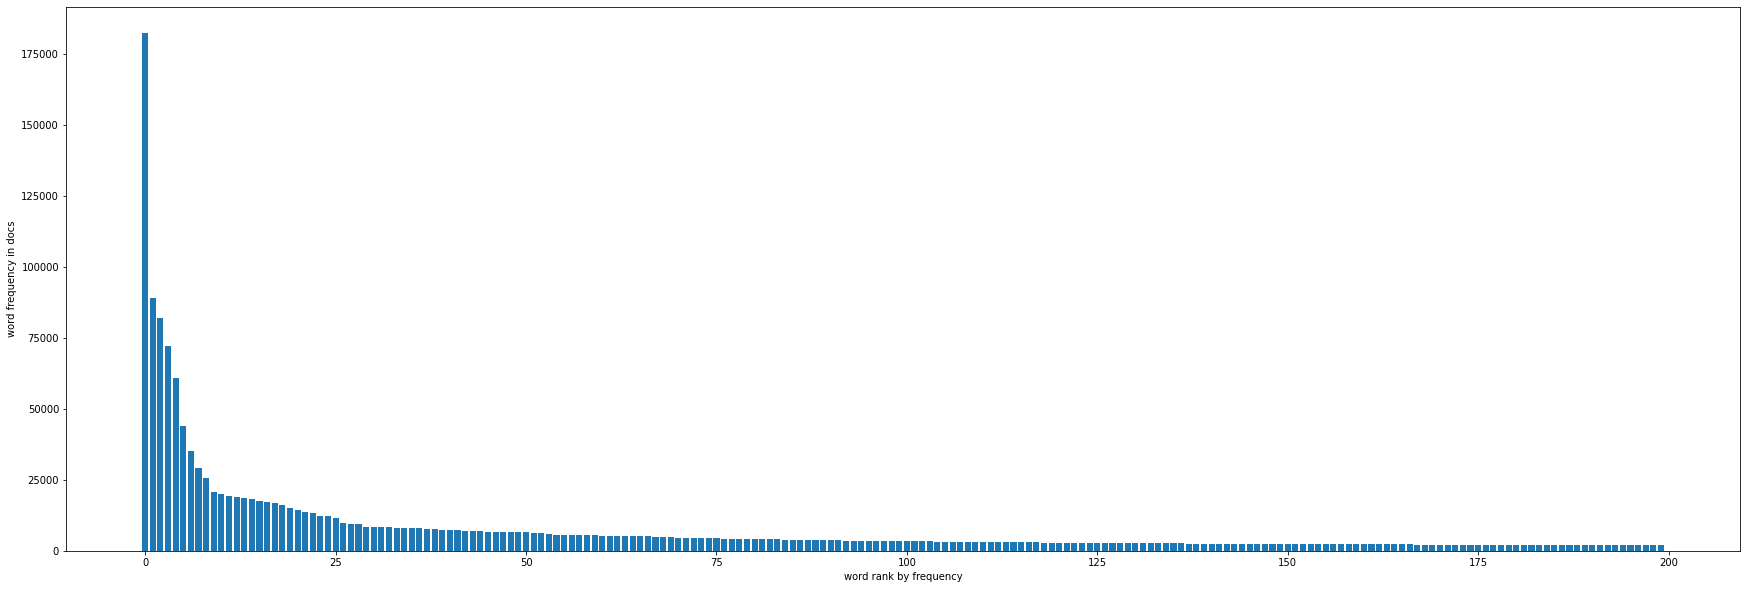

In [ ]:
# Plotting the word distribution by frequency of the top 200 words.
N = 200
fig = plt.figure(figsize=(30,10))
plt.bar(range(N), [w[1] for w in word_counts.most_common(N)])
plt.xlabel('word rank by frequency')
plt.ylabel('word frequency in docs')
fig.show()

In [ ]:
pip install qgrid

     |████████████████████████████████| 890kB 4.4MB/s 
  Created wheel for qgrid: filename=qgrid-1.3.1-py2.py3-none-any.whl size=1761257 sha256=291591b88cdfdd6bcab30eae518b4b95363f7deb2786a5f25a468189ca383169
  Stored in directory: /root/.cache/pip/wheels/51/60/bf/bf05b881c1869ec4e1274a6059f663af1148925c5de1a688d8
Successfully built qgrid


In [ ]:
import sklearn.metrics
from sklearn.metrics import classification_report
from qgrid import show_grid

In [ ]:
from sklearn.model_selection import GridSearchCV

def crossvalidation_report_df(grid_cv): 
    """Convenience function to check the exploration of grid search.

    Creates a simple dataframe that reports the results of a 
    cros-validation experiment. The input grid_cv must be fit. 
    
    Returns a dataframe, sorted by rank of experiment. 
    """
    # pick columns that define each experiment (start with param)
    # and the columns that report mean_test and rank_test results
    cols = [c for c in grid_cv.cv_results_ if (c.startswith('param') or 
                                               c in ['mean_test_score', 'rank_test_score'])]

    # sort original df by rank, and select columns
    return pd.DataFrame(grid_cv.cv_results_).sort_values(by='rank_test_score')[cols]

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

# this defines the base sklearn pipeline we want to tune
sgd_grid_estimator = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=100, tol=None)),
])

'''this defines the configurations. We can play around with different hyperparameters 
until we find those that perform best. We will be comparing 12 different models for each class.'''
sgd_grid_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
    'clf__alpha': (1e-4, 1e-5, 1e-6, 1e-7)
}

sgd_grid_science = GridSearchCV(sgd_grid_estimator, sgd_grid_parameters, verbose=1)
sgd_grid_sports = GridSearchCV(sgd_grid_estimator, sgd_grid_parameters, verbose=1)
sgd_grid_world = GridSearchCV(sgd_grid_estimator, sgd_grid_parameters, verbose=1)
sgd_grid_business = GridSearchCV(sgd_grid_estimator, sgd_grid_parameters, verbose=1)
sgd_grid = GridSearchCV(sgd_grid_estimator, sgd_grid_parameters, verbose=1)

### Science Binary Classifier

In [ ]:
'''
Now we are going to train a binary classification model for each of the 4 classes of the AG News, starting with the 
class "scicence". This fitts 5 folds for each of the 12 candidates, totalling 60 fits, and finds the best 
performing fit.'''
sgd_grid_science.fit(train.text, train.science_int)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 18.2min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        p

In [ ]:
'''We rank the fits by mean test score. The best working fit seems to be alpha 1e-6 and n-gram range of up to 3 words.
Alpha 1e-3 performs significally worse than the rest.'''
crossvalidation_report_df(sgd_grid_science)

,param_clf__alpha,param_vect__ngram_range,params,mean_test_score,rank_test_score
5,1e-06,"(1, 3)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.942181,1
4,1e-06,"(1, 2)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.940327,2
8,1e-09,"(1, 3)","{'clf__alpha': 1e-09, 'vect__ngram_range': (1,...",0.935690,3
11,1e-12,"(1, 3)","{'clf__alpha': 1e-12, 'vect__ngram_range': (1,...",0.935009,4
7,1e-09,"(1, 2)","{'clf__alpha': 1e-09, 'vect__ngram_range': (1,...",0.932999,5
10,1e-12,"(1, 2)","{'clf__alpha': 1e-12, 'vect__ngram_range': (1,...",0.932745,6
3,1e-06,"(1, 1)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.926354,7
6,1e-09,"(1, 1)","{'clf__alpha': 1e-09, 'vect__ngram_range': (1,...",0.903808,8
9,1e-12,"(1, 1)","{'clf__alpha': 1e-12, 'vect__ngram_range': (1,...",0.903435,9
0,0.001,"(1, 1)","{'clf__alpha': 0.001, 'vect__ngram_range': (1,...",0.822726,10


In [ ]:
'''We select and evaluate the best fit on the test data using accuracy, precision and recall.
The model performs well. Precision and recall are balanced. 
It performs better on the negative class (not science). 
This is expected, as the dataset is imbalanced. It contains 3 times more non-scientific texts 
than scientific texts.'''
sgd_best = sgd_grid_science.best_estimator_
print('BEST PARAMS:', sgd_grid_science.best_params_)
print(classification_report(test.science_int, 
                            sgd_best.predict(test.text), 
                            target_names=['negative', 'positive']))

BEST PARAMS: {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}
              precision    recall  f1-score   support

    negative       0.96      0.96      0.96      7463
    positive       0.89      0.88      0.88      2537

    accuracy                           0.94     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.94      0.94      0.94     10000



In [ ]:
'''We define a function to sort words by weights to see what words are most and least associated 
with scientific articles.'''
def sort_feature_weights(sk_pipe, fkey='vect', wkey='clf',i=0):
    F = sk_pipe[fkey].get_feature_names()
    W = sk_pipe[wkey].coef_[i]
    return sorted(zip(F, W), key=lambda fw: fw[1])

In [ ]:
'''The worlds below are most associated with scientific articles.
All the words identified are logically related to science.'''
science_best_weights = sort_feature_weights(sgd_best, i=0)
science_best_weights = sorted(science_best_weights, key=lambda fw: fw[1], reverse=True)
print('Model weights associated with science articles')
science_best_weights[:20]

Model weights associated with science articles


[('space', 6.972020305040656),
 ('nasa', 6.179498853227548),
 ('ap', 5.7653529529006535),
 ('software', 5.622390981053731),
 ('internet', 5.58180773499295),
 ('scientists', 5.276840142752125),
 ('apple', 5.081326025352972),
 ('washingtonpost com', 4.932115143073133),
 ('linux', 4.86421991498195),
 ('microsoft', 4.813672429660281),
 ('washingtonpost', 4.765994811189612),
 ('web', 4.72717185379651),
 ('reuters', 4.554448317728398),
 ('online', 4.517296469892175),
 ('com', 4.507327626459249),
 ('computer', 4.273914072157427),
 ('science', 4.171190849282465),
 ('technology', 4.134804864225583),
 ('researchers', 3.8215106047691636),
 ('spam', 3.8081190992356833)]

In [ ]:
print('Model weights least associated with science articles')
science_best_weights[-20:]

Model weights least associated with science articles


[('seattle', -2.549968897771642),
 ('economic', -2.5551194790483382),
 ('sbc', -2.564946459898931),
 ('president', -2.6477741046993537),
 ('economy', -2.6702023332389104),
 ('us', -2.712888052571279),
 ('cup', -2.716520423210864),
 ('oil', -2.726175789844483),
 ('his', -2.733506017831803),
 ('toronto', -2.735568687100355),
 ('stocks', -2.753429933041969),
 ('saturday', -2.7761079893947485),
 ('sunday', -3.0263704670498925),
 ('new york', -3.1607744919108125),
 ('york', -3.2036393281031943),
 ('iraq', -3.2302278958749238),
 ('football', -3.2604423961030666),
 ('coach', -3.3284309900532754),
 ('yesterday', -4.014380153352625),
 ('hellip', -4.204872184506804)]

### Sports Binary Classifier

In [ ]:
sgd_grid_sports.fit(train.text, train.sports_int)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 23.7min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        p

In [ ]:
crossvalidation_report_df(sgd_grid_sports)

,param_clf__alpha,param_vect__ngram_range,params,mean_test_score,rank_test_score
4,1e-05,"(1, 2)","{'clf__alpha': 1e-05, 'vect__ngram_range': (1,...",0.983718,1
5,1e-05,"(1, 3)","{'clf__alpha': 1e-05, 'vect__ngram_range': (1,...",0.983045,2
3,1e-05,"(1, 1)","{'clf__alpha': 1e-05, 'vect__ngram_range': (1,...",0.982700,3
8,1e-06,"(1, 3)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.982236,4
7,1e-06,"(1, 2)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.981982,5
11,1e-07,"(1, 3)","{'clf__alpha': 1e-07, 'vect__ngram_range': (1,...",0.981663,6
10,1e-07,"(1, 2)","{'clf__alpha': 1e-07, 'vect__ngram_range': (1,...",0.981073,7
6,1e-06,"(1, 1)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.975718,8
0,0.0001,"(1, 1)","{'clf__alpha': 0.0001, 'vect__ngram_range': (1...",0.975582,9
1,0.0001,"(1, 2)","{'clf__alpha': 0.0001, 'vect__ngram_range': (1...",0.972191,10


In [ ]:
sgd_best = sgd_grid_sports.best_estimator_
print('BEST PARAMS:', sgd_grid_sports.best_params_)
# eval
print(classification_report(test.sports_int, 
                            sgd_best.predict(test.text), 
                            target_names=['negative', 'positive']))

BEST PARAMS: {'clf__alpha': 1e-05, 'vect__ngram_range': (1, 2)}
              precision    recall  f1-score   support

    negative       0.99      0.99      0.99      7542
    positive       0.96      0.98      0.97      2458

    accuracy                           0.99     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
sports_best_weights = sort_feature_weights(sgd_best, i=0)
sports_best_weights = sorted(sports_best_weights, key=lambda fw: fw[1], reverse=True)
print('Model weights associated with sports articles')
sports_best_weights[:20]

Model weights associated with sports articles


[('coach', 5.683228411976702),
 ('football', 5.4726343411208935),
 ('baseball', 5.176027459782883),
 ('cup', 5.042013294499793),
 ('team', 4.713192402959097),
 ('olympic', 4.6654597236030835),
 ('sports', 4.392641146686983),
 ('stadium', 4.070172883474322),
 ('cricket', 4.018975659463687),
 ('olympics', 3.9450180336290757),
 ('league', 3.932128326035872),
 ('season', 3.931762447854535),
 ('teams', 3.720427540877217),
 ('players', 3.634524971676115),
 ('basketball', 3.5995070111786056),
 ('nascar', 3.5576392981157614),
 ('nhl', 3.366562744533813),
 ('championship', 3.280358014655712),
 ('quarterback', 3.2417336774504437),
 ('nfl', 3.144192920423137)]

In [ ]:
print('Model weights least associated with sports articles')
sports_best_weights[-20:]

Model weights least associated with sports articles


[('minister', -2.180424341747086),
 ('industry', -2.1828684542986356),
 ('business', -2.2166715239439276),
 ('scientists', -2.2610776286736556),
 ('software', -2.2655744641458115),
 ('market', -2.272661484465743),
 ('video', -2.276341649212847),
 ('government', -2.294909016977513),
 ('iraq', -2.3807308148355646),
 ('music', -2.4067280146710806),
 ('election', -2.415644862037754),
 ('presidential', -2.4694211263111385),
 ('microsoft', -2.582944977560182),
 ('technology', -2.5915383671383037),
 ('computer', -2.6703366672545594),
 ('athens greece', -2.7300296174643464),
 ('space', -2.754015410762396),
 ('company', -2.8735354130807633),
 ('president', -3.0837884363464854),
 ('afp', -5.045503467937966)]

### World Binary Classifier

In [ ]:
sgd_grid_world.fit(train.text, train.world_int)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 17.0min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        p

In [ ]:
crossvalidation_report_df(sgd_grid_world)

,param_clf__alpha,param_vect__ngram_range,params,mean_test_score,rank_test_score
5,1e-06,"(1, 3)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.954918,1
4,1e-06,"(1, 2)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.953545,2
8,1e-09,"(1, 3)","{'clf__alpha': 1e-09, 'vect__ngram_range': (1,...",0.949754,3
11,1e-12,"(1, 3)","{'clf__alpha': 1e-12, 'vect__ngram_range': (1,...",0.949663,4
10,1e-12,"(1, 2)","{'clf__alpha': 1e-12, 'vect__ngram_range': (1,...",0.947445,5
7,1e-09,"(1, 2)","{'clf__alpha': 1e-09, 'vect__ngram_range': (1,...",0.947027,6
3,1e-06,"(1, 1)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.940836,7
9,1e-12,"(1, 1)","{'clf__alpha': 1e-12, 'vect__ngram_range': (1,...",0.921927,8
6,1e-09,"(1, 1)","{'clf__alpha': 1e-09, 'vect__ngram_range': (1,...",0.920963,9
0,0.001,"(1, 1)","{'clf__alpha': 0.001, 'vect__ngram_range': (1,...",0.872781,10


In [ ]:
sgd_best = sgd_grid_world.best_estimator_
print('BEST PARAMS:', sgd_grid_world.best_params_)
# eval
print(classification_report(test.world_int, 
                            sgd_best.predict(test.text), 
                            target_names=['negative', 'positive']))

BEST PARAMS: {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}
              precision    recall  f1-score   support

    negative       0.96      0.97      0.97      7491
    positive       0.92      0.89      0.90      2509

    accuracy                           0.95     10000
   macro avg       0.94      0.93      0.94     10000
weighted avg       0.95      0.95      0.95     10000



In [ ]:
world_best_weights = sort_feature_weights(sgd_best, i=0)
world_best_weights = sorted(world_best_weights, key=lambda fw: fw[1], reverse=True)
print('Model weights associated with world articles')
world_best_weights[:20]

Model weights associated with world articles


[('afp', 10.727143660692272),
 ('canadian press', 7.010475135038961),
 ('iraq', 6.235173437398892),
 ('president', 5.535610272160231),
 ('nuclear', 5.378804353471556),
 ('military', 5.2416805368432495),
 ('iraqi', 4.823139953589492),
 ('athens greece', 4.651846091612188),
 ('palestinian', 4.63811672614713),
 ('elections', 4.579864782300327),
 ('troops', 4.309297230241819),
 ('iran', 4.284152600887479),
 ('un', 4.1330062674369685),
 ('israel', 4.082789051144803),
 ('peace', 3.9312844752352833),
 ('baghdad', 3.8415868609697963),
 ('terrorism', 3.768960160117543),
 ('ap tokyo', 3.7364536772221983),
 ('afghanistan', 3.6744497467727606),
 ('arafat', 3.6650492298401622)]

In [ ]:
print('Model weights least associated with world articles')
world_best_weights[-20:]

Model weights least associated with world articles


[('company', -2.4347233492761164),
 ('game', -2.533493297610319),
 ('tokyo reuters tokyo', -2.568439379461576),
 ('team', -2.587366021990277),
 ('amp', -2.608543393346857),
 ('football', -2.6225316677135195),
 ('web', -2.6791456219784915),
 ('coach', -2.822234754422674),
 ('new york reuters', -2.826218520240774),
 ('york reuters', -2.826218520240774),
 ('cup', -2.8397079028566283),
 ('computer', -2.9284934078205413),
 ('ap brazil', -3.1266212965352786),
 ('online', -3.127272682283846),
 ('software', -3.2745970616491222),
 ('microsoft', -3.356730524995677),
 ('space', -3.5052323946189863),
 ('tokyo reuters', -4.053599325361613),
 ('39', -4.082464943468167),
 ('internet', -4.186820646675609)]

### Business Binary Classifier

In [ ]:
sgd_grid_business.fit(train.text, train.business_int)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 23.8min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        p

In [ ]:
crossvalidation_report_df(sgd_grid_business)

,param_clf__alpha,param_vect__ngram_range,params,mean_test_score,rank_test_score
1,1e-05,"(1, 2)","{'clf__alpha': 1e-05, 'vect__ngram_range': (1,...",0.942309,1
2,1e-05,"(1, 3)","{'clf__alpha': 1e-05, 'vect__ngram_range': (1,...",0.941163,2
5,1e-06,"(1, 3)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.941054,3
8,1e-07,"(1, 3)","{'clf__alpha': 1e-07, 'vect__ngram_range': (1,...",0.939636,4
4,1e-06,"(1, 2)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.938990,5
0,1e-05,"(1, 1)","{'clf__alpha': 1e-05, 'vect__ngram_range': (1,...",0.938545,6
7,1e-07,"(1, 2)","{'clf__alpha': 1e-07, 'vect__ngram_range': (1,...",0.935745,7
11,1e-18,"(1, 3)","{'clf__alpha': 1e-18, 'vect__ngram_range': (1,...",0.934709,8
10,1e-18,"(1, 2)","{'clf__alpha': 1e-18, 'vect__ngram_range': (1,...",0.932027,9
3,1e-06,"(1, 1)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.925427,10


In [ ]:
sgd_best = sgd_grid_business.best_estimator_
print('BEST PARAMS:', sgd_grid_business.best_params_)
# eval
print(classification_report(test.business_int, 
                            sgd_best.predict(test.text), 
                            target_names=['negative', 'positive']))

BEST PARAMS: {'clf__alpha': 1e-05, 'vect__ngram_range': (1, 2)}
              precision    recall  f1-score   support

    negative       0.95      0.97      0.96      7504
    positive       0.91      0.85      0.88      2496

    accuracy                           0.94     10000
   macro avg       0.93      0.91      0.92     10000
weighted avg       0.94      0.94      0.94     10000



In [ ]:
business_best_weights = sort_feature_weights(sgd_best, i=0)
business_best_weights = sorted(business_best_weights, key=lambda fw: fw[1], reverse=True)
print('Model weights associated with business articles')
business_best_weights[:20]

Model weights associated with business articles


[('tax', 4.443141387739774),
 ('airlines', 4.315391656844055),
 ('hellip', 4.290637725498123),
 ('insurance', 3.9461546645816172),
 ('bank', 3.838011476720672),
 ('economy', 3.7667262833436537),
 ('oil', 3.7030966349403087),
 ('investment', 3.6151246550316207),
 ('stock', 3.609559325931138),
 ('economic', 3.5896595372533104),
 ('enron', 3.5000217817968293),
 ('investors', 3.2844556864658245),
 ('profits', 3.233963031051553),
 ('prices', 3.1891348295053694),
 ('retailer', 3.1547631619233143),
 ('amp', 3.112996535363448),
 ('yukos', 3.0456663135025304),
 ('nyse', 3.026350882342812),
 ('oracle 39', 3.0233431925068395),
 ('martha stewart', 3.0135331650538815)]

In [ ]:
print('Model weights least associated with business articles')
business_best_weights[-20:]

Model weights least associated with business articles


[('iraq', -2.2772902525998946),
 ('military', -2.2811600307183952),
 ('nuclear', -2.289605217578943),
 ('com', -2.310437963999429),
 ('space', -2.4092534108846837),
 ('internet', -2.4254462045451093),
 ('game', -2.5498636181987013),
 ('newsfactor', -2.5629620154456467),
 ('nasa', -2.6489619520681926),
 ('apple', -2.7301623910986645),
 ('team', -2.747176549421565),
 ('linux', -2.8292440839460693),
 ('washingtonpost', -2.837529405213588),
 ('36', -2.850745273612542),
 ('washingtonpost com', -2.9205137348224905),
 ('software', -2.9820287999812702),
 ('canadian press', -3.29269878480387),
 ('york stocks', -4.612216365399569),
 ('afp', -5.23541972269084),
 ('ap', -11.499925350613216)]

### Precision and Recall

In [ ]:
'''We tune the thresholds of the business class binary classifier to experiment with high-recall and high-precision 
classifiers. We compare 5 thresholds, -2, -1, 0, 1, and 2, and we plot the precision and recall curve.'''
test_scores = sgd_best.decision_function(test.text)
# and afterwards we can alter the threshold
for threshold in [-2, -1, 0, 1, 2]:
    print("Metrics with threshold={}".format(threshold))
    print(classification_report(test.business_int,
                                [1 if s>threshold else 0 for s in test_scores],
                                target_names=['negative', 'positive']))
    print()


Metrics with threshold=-2
              precision    recall  f1-score   support

    negative       1.00      0.09      0.17      7504
    positive       0.27      1.00      0.42      2496

    accuracy                           0.32     10000
   macro avg       0.63      0.55      0.30     10000
weighted avg       0.82      0.32      0.24     10000


Metrics with threshold=-1
              precision    recall  f1-score   support

    negative       0.99      0.76      0.86      7504
    positive       0.57      0.97      0.72      2496

    accuracy                           0.81     10000
   macro avg       0.78      0.86      0.79     10000
weighted avg       0.88      0.81      0.82     10000


Metrics with threshold=0
              precision    recall  f1-score   support

    negative       0.95      0.97      0.96      7504
    positive       0.91      0.85      0.88      2496

    accuracy                           0.94     10000
   macro avg       0.93      0.91      0.92     1

In [ ]:
pr_sgd_best = sklearn.metrics.precision_recall_curve(test.business_int, 
                                                     sgd_best.decision_function(test.text), 
                                                     pos_label=1)

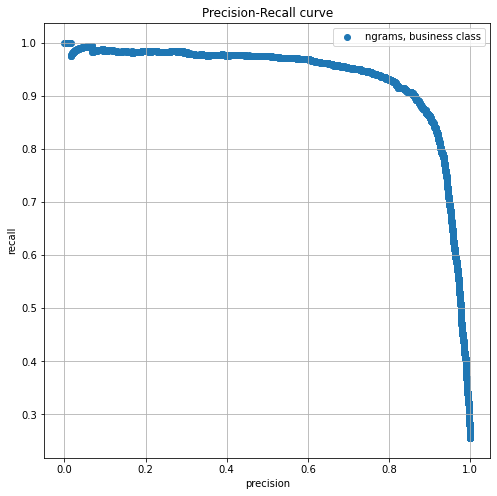

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Precision-Recall curve')
plt.xlabel('precision')
plt.ylabel('recall')
plt.scatter(y=pr_sgd_best[0], x=pr_sgd_best[1], label='ngrams, business class')
plt.grid(True)
plt.legend()

### Multiclass Classifier

In [ ]:
'''Now we are going to experiment with multicass methods that decide one among the four classes.
We fit 5 folds for each of the 12 candidates, using the alpha values that worked best 
during the previous experiments.'''
sgd_grid.fit(train.text, train.label_int)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 42.2min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        p

In [ ]:
# The best performing model still uses alpha 1e-5 and ngram_range (1,2)
crossvalidation_report_df(sgd_grid)

,param_clf__alpha,param_vect__ngram_range,params,mean_test_score,rank_test_score
4,1e-05,"(1, 2)","{'clf__alpha': 1e-05, 'vect__ngram_range': (1,...",0.916790,1
5,1e-05,"(1, 3)","{'clf__alpha': 1e-05, 'vect__ngram_range': (1,...",0.914545,2
8,1e-06,"(1, 3)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.912499,3
3,1e-05,"(1, 1)","{'clf__alpha': 1e-05, 'vect__ngram_range': (1,...",0.912190,4
11,1e-07,"(1, 3)","{'clf__alpha': 1e-07, 'vect__ngram_range': (1,...",0.911408,5
7,1e-06,"(1, 2)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.910763,6
10,1e-07,"(1, 2)","{'clf__alpha': 1e-07, 'vect__ngram_range': (1,...",0.907608,7
0,0.0001,"(1, 1)","{'clf__alpha': 0.0001, 'vect__ngram_range': (1...",0.901554,8
1,0.0001,"(1, 2)","{'clf__alpha': 0.0001, 'vect__ngram_range': (1...",0.898408,9
2,0.0001,"(1, 3)","{'clf__alpha': 0.0001, 'vect__ngram_range': (1...",0.892617,10


In [ ]:
'''The model performs well. Precision and recall are balanced.
The model performs best at identifying sports articles. This could be due to sports articles
using a very specific set of words. Science, world, and business are more likely to share some words.'''
sgd_best = sgd_grid.best_estimator_
print('BEST PARAMS:', sgd_grid.best_params_)
print(classification_report(test.label_int, 
                            sgd_best.predict(test.text), 
                            target_names=['science', 'sports', 'world', 'business']))

BEST PARAMS: {'clf__alpha': 1e-05, 'vect__ngram_range': (1, 2)}
              precision    recall  f1-score   support

     science       0.89      0.90      0.90      2537
      sports       0.95      0.99      0.97      2458
       world       0.93      0.90      0.91      2509
    business       0.90      0.88      0.89      2496

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [ ]:
def sort_feature_weights(sk_pipe, fkey='vect', wkey='clf',i=0):
    F = sk_pipe[fkey].get_feature_names()
    W = sk_pipe[wkey].coef_[i]
    return sorted(zip(F, W), key=lambda fw: fw[1])

In [ ]:
# convenience function: given a feature ngram, returns the number of "grams"
# i.e. 1 for unigrams, 2 for bigrams, ....
# simply counts the number of elements separated by space (this is how sklearn encodes unigrams)
def ngram_order(f):
    """Returns the ngram order of a feature. """
    return len(f.split())

In [ ]:
'''Words and ngrams that don't makes sense for the science class:
yahoo: yahoo science, washignton post: washington post science articles, 
ft com: financial times science articles, moint st: active volcano, 
36 billion: 36 billion dollars lost in data breaches, 36 billion tons of CO2 emissions'''
science_best_weights = sort_feature_weights(sgd_best, i=0)
science_best_weights = sorted(science_best_weights, key=lambda fw: fw[1], reverse=True)
print('Model weights associated with science articles')
science_best_weights[:20]

Model weights associated with science articles


[('space', 6.368602591451835),
 ('internet', 5.3876426011807546),
 ('scientists', 5.342233732673666),
 ('software', 5.313732832675281),
 ('nasa', 5.309192289039093),
 ('apple', 4.60454027508694),
 ('linux', 4.559392609197625),
 ('microsoft', 4.460599636141165),
 ('web', 4.292983901579856),
 ('online', 4.201673736539777),
 ('computer', 4.183333654466882),
 ('researchers', 3.754042982454971),
 ('spam', 3.7467274754937057),
 ('technology', 3.717663269386726),
 ('science', 3.7015444279335927),
 ('com', 3.399816737706761),
 ('users', 3.2504418289695636),
 ('species', 3.183593114681464),
 ('yahoo', 3.1630151172038685),
 ('broadband', 3.1248065078264804)]

In [ ]:
print('Bigram weights associated with science articles')
[fw for fw in science_best_weights if ngram_order(fw[0])==2][:20]

Bigram weights associated with science articles


[('washingtonpost com', 3.0638825996685224),
 ('washington ap', 2.3747831589896404),
 ('video games', 2.342844702476439),
 ('video game', 2.2904994915098307),
 ('open source', 2.112535797204783),
 ('global warming', 2.031817855850907),
 ('big blue', 1.903340780467496),
 ('half life', 1.8918922269565321),
 ('the internet', 1.879529253307511),
 ('from wired', 1.8416918911447846),
 ('wired magazine', 1.837092898036695),
 ('ft com', 1.8237080528506342),
 ('corp 36', 1.7567483492961056),
 ('reports from', 1.7498789635504628),
 ('sun microsystems', 1.7490194767673033),
 ('consumer electronics', 1.7114418453900133),
 ('mount st', 1.7099143141489703),
 ('36 billion', 1.6574763697363475),
 ('york ap', 1.6231571559305573),
 ('ziff davis', 1.59574728910604)]

In [ ]:
'''Words and ngrams that don't makes sense for the sports class:
notre dame: Notre Dame Fighting Irish are the athletic teams that represent the University of Notre Dame.
men 39: maybe related to running shoes'''
sports_best_weights = sort_feature_weights(sgd_best, i=1)
sports_best_weights = sorted(sports_best_weights, key=lambda fw: fw[1], reverse=True)
print('Model weights associated with sports articles')
sports_best_weights[:20]

Model weights associated with sports articles


[('coach', 5.679298646028773),
 ('football', 5.469339659182907),
 ('baseball', 5.173268784579366),
 ('cup', 5.039909284692458),
 ('team', 4.711929828554235),
 ('olympic', 4.6707918024677015),
 ('sports', 4.387550310786523),
 ('stadium', 4.06607101294932),
 ('cricket', 4.015597828484853),
 ('olympics', 3.9501148863966025),
 ('season', 3.9295180408797776),
 ('league', 3.9276446047653515),
 ('teams', 3.721381869025682),
 ('players', 3.6282845641055763),
 ('basketball', 3.603358998746263),
 ('nascar', 3.555603676765379),
 ('nhl', 3.368735452131544),
 ('championship', 3.281888682935428),
 ('quarterback', 3.245616108180874),
 ('nfl', 3.1433868620837893)]

In [ ]:
print('Bigram weights associated with sports articles')
[fw for fw in sports_best_weights if ngram_order(fw[0])==2][:20]

Bigram weights associated with sports articles


[('kobe bryant', 2.411871207378639),
 ('manchester united', 2.309820968298498),
 ('red sox', 2.167846709928851),
 ('formula one', 2.0168821206861907),
 ('world cup', 1.9524099226051435),
 ('grand prix', 1.6829658547695856),
 ('notre dame', 1.5986914911918597),
 ('barry bonds', 1.5789996196069847),
 ('running back', 1.551236483394952),
 ('the nhl', 1.533721166345287),
 ('the nba', 1.5159196688308114),
 ('us open', 1.502389437163275),
 ('gold medal', 1.3571239627829808),
 ('world series', 1.3468246913500053),
 ('hendrick motorsports', 1.329395689128272),
 ('the nfl', 1.3164820658601006),
 ('hall of', 1.3037399150288125),
 ('men 39', 1.2848768686076883),
 ('the yankees', 1.2648817504159795),
 ('sports network', 1.250048795184501)]

In [ ]:
'''Words and ngrams that don't makes sense for the world class:
york stocks and york investors: should make more sense in the business class'''
world_best_weights = sort_feature_weights(sgd_best, i=2)
world_best_weights = sorted(world_best_weights, key=lambda fw: fw[1], reverse=True)
print('Model weights associated with world articles')
world_best_weights[:20]

Model weights associated with world articles


[('afp', 7.209588811284654),
 ('canadian press', 5.697820768370586),
 ('iraq', 5.312526608640608),
 ('nuclear', 4.7322364131295185),
 ('president', 4.48555089853351),
 ('york stocks', 4.376685828959353),
 ('military', 4.354445196365968),
 ('iraqi', 4.054174447488733),
 ('elections', 3.836569811085946),
 ('palestinian', 3.829054979145384),
 ('iran', 3.6657380478725834),
 ('troops', 3.4948381423696517),
 ('terrorism', 3.4368395096861977),
 ('afghanistan', 3.400633041666675),
 ('israel', 3.3585152144520967),
 ('peace', 3.354118639238),
 ('un', 3.249141644885388),
 ('arafat', 3.191202276650594),
 ('prince', 3.1298956511237197),
 ('baghdad', 3.082103121119123)]

In [ ]:
print('Bigram weights associated with world articles')
[fw for fw in world_best_weights if ngram_order(fw[0])==2][:20]

Bigram weights associated with world articles


[('canadian press', 5.697820768370586),
 ('york stocks', 4.376685828959353),
 ('ap tokyo', 2.9768588932645015),
 ('athens greece', 2.7375125543021768),
 ('united nations', 2.718315879917407),
 ('west bank', 2.537113032768164),
 ('ap president', 2.2996720090736598),
 ('prime minister', 2.2765815489849617),
 ('john kerry', 2.0044992250121494),
 ('yasser arafat', 1.9283876178311166),
 ('michael jackson', 1.8772576849048572),
 ('general strike', 1.8723193181512316),
 ('north korea', 1.8529905888516702),
 ('bird flu', 1.8413274131762136),
 ('state department', 1.7240505377208288),
 ('tony blair', 1.7146662271312936),
 ('york investors', 1.672623646504926),
 ('david blunkett', 1.6632668311638028),
 ('ivory coast', 1.6631081318935694),
 ('the un', 1.6604616447001375)]

In [ ]:
'''Words and ngrams that don't makes sense for the business class:
salvation army: many articles related to how salvation army makes money'''
business_best_weights = sort_feature_weights(sgd_best, i=3)
business_best_weights = sorted(business_best_weights, key=lambda fw: fw[1], reverse=True)
print('Model weights associated with business articles')
business_best_weights[:20]

Model weights associated with business articles


[('tax', 4.444486421981836),
 ('airlines', 4.303752554338217),
 ('hellip', 4.283103728979001),
 ('insurance', 3.948433081538409),
 ('bank', 3.8524356384712024),
 ('economy', 3.761372628492039),
 ('oil', 3.699008529361074),
 ('investment', 3.624376927025331),
 ('stock', 3.6034536056460347),
 ('economic', 3.5841924680261203),
 ('enron', 3.5003421332053244),
 ('investors', 3.277164553582265),
 ('profits', 3.2237145422091102),
 ('prices', 3.183076351488505),
 ('retailer', 3.153441115384544),
 ('amp', 3.1028014680103815),
 ('yukos', 3.050224480937139),
 ('nyse', 3.0318361272590786),
 ('oracle 39', 3.020638504936711),
 ('martha stewart', 3.013563488778654)]

In [ ]:
print('Bigram weights associated with positive reviews')
[fw for fw in business_best_weights if ngram_order(fw[0])==2][:20]

Bigram weights associated with positive reviews


[('oracle 39', 3.020638504936711),
 ('martha stewart', 3.013563488778654),
 ('york reuters', 2.7801207658310476),
 ('forbes com', 2.7577254599851475),
 ('salvation army', 2.318541583326025),
 ('world trade', 2.305510169030215),
 ('hellip and', 2.251491998080154),
 ('peoplesoft 39', 1.9723062880379543),
 ('federal reserve', 1.9650091782550603),
 ('dow jones', 1.9578807555991429),
 ('us airways', 1.9000470771822369),
 ('general motors', 1.8900987016022277),
 ('cbs mw', 1.885430221468918),
 ('gordon brown', 1.8823603661452968),
 ('united airlines', 1.8816605786787466),
 ('chief executive', 1.866326482787732),
 ('39 largest', 1.8581471351995484),
 ('the financial', 1.8364931334527008),
 ('inc 39', 1.7094760282383212),
 ('real estate', 1.6778984650622282)]

In [ ]:
sgd_best.predict(['Mbaye Diagne is booked for a challenge with Cesar Azpilicueta - the Chelsea man goes down holding his face while the striker protests he was just trying to shield the ball.'])

array([1])

### Running the models on unseen news articles

In [ ]:
# Load articles dataset found on Kaggle
articles = pd.read_csv('Articles.csv', encoding= 'unicode_escape')

In [ ]:
articles.head()

,Article,Date,Heading,NewsType
0,KARACHI: The Sindh government has decided to b...,1/1/2015,sindh govt decides to cut public transport far...,business
1,HONG KONG: Asian markets started 2015 on an up...,1/2/2015,asia stocks up in new year trad,business
2,HONG KONG: Hong Kong shares opened 0.66 perce...,1/5/2015,hong kong stocks open 0.66 percent lower,business
3,HONG KONG: Asian markets tumbled Tuesday follo...,1/6/2015,asian stocks sink euro near nine year,business
4,NEW YORK: US oil prices Monday slipped below $...,1/6/2015,us oil prices slip below 50 a barr,business


In [ ]:
# Articles are from 2015 and 2016
articles['Date'].value_counts()

8/1/2016      27
8/2/2016      24
6/3/2016      21
8/5/2016      20
8/4/2016      19
              ..
7/8/2015       1
9/25/2016      1
12/2/2015      1
10/29/2016     1
1/7/2015       1
Name: Date, Length: 666, dtype: int64

In [ ]:
'''The dataset only contains sports and business articles. We can the  sports and business 
binary classifier top models on this dataset to see how well they perform on unseen and more recent data.'''
articles['NewsType'].value_counts()

sports      1408
business    1284
Name: NewsType, dtype: int64

In [ ]:
articles['business_int'] = articles['NewsType'].replace({'business': 1, 'sports': 0})

In [ ]:
articles['business_int'].value_counts()

0    1408
1    1284
Name: business_int, dtype: int64

In [ ]:
articles['sports_int'] = articles['NewsType'].replace({'business': 0, 'sports': 1})

In [ ]:
articles['sports_int'].value_counts()

1    1408
0    1284
Name: sports_int, dtype: int64

In [ ]:
articles.head()

,Article,Date,Heading,NewsType,business_int,sports_int
0,KARACHI: The Sindh government has decided to b...,1/1/2015,sindh govt decides to cut public transport far...,business,1,0
1,HONG KONG: Asian markets started 2015 on an up...,1/2/2015,asia stocks up in new year trad,business,1,0
2,HONG KONG: Hong Kong shares opened 0.66 perce...,1/5/2015,hong kong stocks open 0.66 percent lower,business,1,0
3,HONG KONG: Asian markets tumbled Tuesday follo...,1/6/2015,asian stocks sink euro near nine year,business,1,0
4,NEW YORK: US oil prices Monday slipped below $...,1/6/2015,us oil prices slip below 50 a barr,business,1,0


In [ ]:
# Evaluating the business binary classifier
sgd_best = sgd_grid_business.best_estimator_
print('BEST PARAMS:', sgd_grid_business.best_params_)
print(classification_report(articles.business_int, 
                            sgd_best.predict(articles.Article), 
                            target_names=['negative', 'positive']))

BEST PARAMS: {'clf__alpha': 1e-05, 'vect__ngram_range': (1, 2)}
              precision    recall  f1-score   support

    negative       0.86      1.00      0.93      1408
    positive       1.00      0.83      0.90      1284

    accuracy                           0.92      2692
   macro avg       0.93      0.91      0.91      2692
weighted avg       0.93      0.92      0.91      2692



In [ ]:
# Evaluating the business binary classifier
sgd_best = sgd_grid_sports.best_estimator_
print('BEST PARAMS:', sgd_grid_sports.best_params_)
print(classification_report(articles.sports_int, 
                            sgd_best.predict(articles.Article), 
                            target_names=['negative', 'positive']))

BEST PARAMS: {'clf__alpha': 1e-05, 'vect__ngram_range': (1, 2)}
              precision    recall  f1-score   support

    negative       0.98      1.00      0.99      1284
    positive       1.00      0.98      0.99      1408

    accuracy                           0.99      2692
   macro avg       0.99      0.99      0.99      2692
weighted avg       0.99      0.99      0.99      2692



In [ ]:
'''There is no noticeable divergence in terms of performance when compared to the previous experiment. 
However, when we test the models on this new dataset, we see that precision is considerably higher than recall. 
This is due to the models being optimized for overall accuracy in a dataset that was imbalanced towards the 
negative class, while this new dataset is perfectly balanced.'''

### Spacy NLP

In [ ]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
import spacy
from tqdm import tqdm
import qgrid

In [ ]:
spacy_nlp = spacy.load('en_core_web_sm')

In [ ]:
N=100
train_nlp = [spacy_nlp(t) for t in tqdm(train.text[:100])]

100%|██████████| 100/100 [00:01<00:00, 54.87it/s]


In [ ]:
sentence = train_nlp[0]

In [ ]:
[(t.text, t.lemma_,t.tag_,t.ent_type_) for t in sentence]

[('John', 'John', 'NNP', 'PERSON'),
 ('Souza', 'Souza', 'NNP', 'PERSON'),
 (',', ',', ',', ''),
 ('a', 'a', 'DT', ''),
 ('volunteer', 'volunteer', 'NN', ''),
 ('with', 'with', 'IN', ''),
 ('the', 'the', 'DT', ''),
 ('Boone', 'Boone', 'NNP', 'GPE'),
 ('County', 'County', 'NNP', 'GPE'),
 ('chapter', 'chapter', 'NN', ''),
 ('of', 'of', 'IN', ''),
 ('the', 'the', 'DT', 'ORG'),
 ('American', 'American', 'NNP', 'ORG'),
 ('Red', 'Red', 'NNP', 'ORG'),
 ('Cross', 'Cross', 'NNP', 'ORG'),
 (',', ',', ',', ''),
 ('is', 'be', 'VBZ', ''),
 ('the', 'the', 'DT', ''),
 ('second', 'second', 'JJ', ''),
 ('Columbia', 'Columbia', 'NNP', 'ORG'),
 ('resident', 'resident', 'NN', ''),
 ('to', 'to', 'TO', ''),
 ('join', 'join', 'VB', ''),
 ('efforts', 'effort', 'NNS', ''),
 ('to', 'to', 'TO', ''),
 ('assist', 'assist', 'VB', ''),
 ('people', 'people', 'NNS', ''),
 ('who', 'who', 'WP', ''),
 ('were', 'be', 'VBD', ''),
 ('affected', 'affect', 'VBN', ''),
 ('by', 'by', 'IN', ''),
 ('Tropical', 'Tropical', 'NNP', '

In [ ]:
for e in sentence.ents:
    print('ENTITY', e, 'TYPE', e.label_, 'LEMMA', e.lemma_)

ENTITY John Souza TYPE PERSON LEMMA John Souza
ENTITY Boone County TYPE GPE LEMMA Boone County
ENTITY the American Red Cross TYPE ORG LEMMA the American Red Cross
ENTITY Columbia TYPE ORG LEMMA Columbia
ENTITY Tropical Storm Bonnie TYPE PERSON LEMMA Tropical Storm Bonnie
ENTITY Hurricane Charley TYPE ORG LEMMA Hurricane Charley


In [ ]:
sentence = train_nlp[0]
print('SENTENCE', sentence)
for e in sentence.ents:
    print('ENTITY', e, 'TYPE', e.label_, 'LEMMA', e.lemma_)

SENTENCE John Souza, a volunteer with the Boone County chapter of the American Red Cross, is the second Columbia resident to join efforts to assist people who were affected by Tropical Storm Bonnie and Hurricane Charley.
ENTITY John Souza TYPE PERSON LEMMA John Souza
ENTITY Boone County TYPE GPE LEMMA Boone County
ENTITY the American Red Cross TYPE ORG LEMMA the American Red Cross
ENTITY Columbia TYPE ORG LEMMA Columbia
ENTITY Tropical Storm Bonnie TYPE PERSON LEMMA Tropical Storm Bonnie
ENTITY Hurricane Charley TYPE ORG LEMMA Hurricane Charley


In [ ]:
[(t.lemma_, t.tag_) for t in sentence if t.tag_ in ['JJ', 'NN', 'NNP']]

[('John', 'NNP'),
 ('Souza', 'NNP'),
 ('volunteer', 'NN'),
 ('Boone', 'NNP'),
 ('County', 'NNP'),
 ('chapter', 'NN'),
 ('American', 'NNP'),
 ('Red', 'NNP'),
 ('Cross', 'NNP'),
 ('second', 'JJ'),
 ('Columbia', 'NNP'),
 ('resident', 'NN'),
 ('Tropical', 'NNP'),
 ('Storm', 'NNP'),
 ('Bonnie', 'NNP'),
 ('Hurricane', 'NNP'),
 ('Charley', 'NNP')]

In [ ]:
list(sentence.noun_chunks)

[John Souza,
 a volunteer,
 the Boone County chapter,
 the American Red Cross,
 the second Columbia resident,
 efforts,
 people,
 who,
 Tropical Storm Bonnie,
 Hurricane Charley]

In [ ]:
from spacy import displacy
displacy.render(sentence, style="dep")

'<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" xml:lang="en" id="8e24037b2fc94ccdbd1afc70b65466d6-0" class="displacy" width="6175" height="574.5" direction="ltr" style="max-width: none; height: 574.5px; color: #000000; background: #ffffff; font-family: Arial; direction: ltr">\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="484.5">\n    <tspan class="displacy-word" fill="currentColor" x="50">John</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="50">PROPN</tspan>\n</text>\n\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="484.5">\n    <tspan class="displacy-word" fill="currentColor" x="225">Souza,</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="225">PROPN</tspan>\n</text>\n\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="484.5">\n    <tspan class="displacy-word" fill="currentColor" x="400">a</tspan>\n    <tspan class="displacy-

In [ ]:
from collections import Counter, defaultdict

def entity_aggregation(reviews_nlp, reviews_label, 
                       ENTITY_TYPES=['PERSON', 'ORG', 'GPE'], 
                       as_df=True):
    ENTITY_TYPES = set(ENTITY_TYPES)
    entity_agg = defaultdict(Counter)
    for sentence, label in zip(reviews_nlp, reviews_label):
        for entity in sentence.ents:
            etype = entity.label_                        
            lemma = entity.lemma_
            if etype in ENTITY_TYPES:
               entity_agg[(lemma, etype)][label] += 1
    if not as_df:                    
       return entity_agg
         
    all_labels = set(reviews_label)
    all_records = []
    for entity_tuple, counts in entity_agg.items():
        entity_name = entity_tuple[0]
        entity_type = entity_tuple[1]
        entity_ndocs = sum(counts.values())
        entity_record = { 'name': entity_name,
                          'type': entity_type,
                          'num_docs': entity_ndocs }
        for l in all_labels:
            entity_record[l] = counts.get(l,0)/entity_ndocs
        all_records.append(entity_record)
    df = pd.DataFrame.from_records(all_records)
    df.sort_values(by='num_docs', ascending=False, inplace=True)
    return df

In [ ]:
eagg = entity_aggregation(train_nlp, train.label)
eagg

,name,type,num_docs,Sports,Business,Science,World
48,Reuters,ORG,9,0.000000,0.555556,0.111111,0.333333
72,AP,ORG,7,0.428571,0.000000,0.142857,0.428571
73,Australia,GPE,4,0.750000,0.000000,0.250000,0.000000
41,US,GPE,4,0.000000,0.500000,0.250000,0.250000
7,Britain,GPE,3,0.666667,0.000000,0.333333,0.000000
...,...,...,...,...,...,...,...
83,Queens,GPE,1,0.000000,0.000000,1.000000,0.000000
84,Anthony Dupuis,PERSON,1,1.000000,0.000000,0.000000,0.000000
86,\$us1,ORG,1,1.000000,0.000000,0.000000,0.000000
87,the International Ice Hockey Federation,ORG,1,1.000000,0.000000,0.000000,0.000000


In [ ]:
qgrid.show_grid(eagg)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [ ]:
def spacy_cosine_sim(text1, text2):
    nlp1 = spacy_nlp(text1)
    nlp2 = spacy_nlp(text2)
    return nlp1.similarity(nlp2)

In [ ]:
spacy_cosine_sim('apple', 'pear')

/usr/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)


0.6525304179939787

In [ ]:
spacy_nlp('movie').vector

array([ 1.0853081 , -0.95277804, -0.52203417, -0.22894484,  3.8408265 ,
       -0.52309185,  2.2309175 , -0.7608305 ,  0.00918591,  3.0352554 ,
        3.0731952 ,  2.8509495 ,  0.9143617 , -0.38636526, -0.9993022 ,
       -1.8665577 ,  1.1666148 ,  2.6115978 , -2.8124354 , -1.9813902 ,
       -0.30030924,  3.1977375 , -0.82191044, -0.5997441 , -0.20232144,
        0.29179978,  0.12290084, -1.9470054 ,  2.9627793 , -1.638324  ,
        3.7976391 , -0.99174714, -0.1010555 , -0.5122336 ,  2.0900705 ,
       -2.080437  ,  1.608235  ,  0.48852634, -3.3623843 ,  0.9613968 ,
        2.4552965 ,  3.510927  , -1.3208785 , -5.038473  ,  0.9138061 ,
       -0.7958424 ,  2.0392778 ,  0.40498787, -0.31665248,  4.749779  ,
       -0.28265232, -2.1713395 , -0.79527724, -2.599558  , -1.422917  ,
        1.5015397 ,  0.90351844,  0.94612896,  0.91659474, -0.72378254,
        0.504268  , -0.22485632, -0.99144506, -0.6780238 ,  0.25906777,
       -2.5456634 ,  0.24699247, -3.9501019 , -3.417646  ,  3.12